# Sentiment Classification Using RNN

Import the modules.

In [1]:
import re
import nltk
import numpy as np
import pandas as pd
from numpy import argmax
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from nltk.corpus import stopwords
from keras.layers import LSTM
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

%matplotlib inline

Using TensorFlow backend.


In [2]:
nltk.download('stopwords')
stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maninaya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Download the dataset.

In [3]:
data=pd.read_csv('https://www.dropbox.com/s/8yq0edd4q908xqw/airline_sentiment.csv?dl=1')

In [4]:
data.shape

(11541, 2)

A sample of the dataset looks as follows.

In [5]:
data.head()

,airline_sentiment,text
0,1,@VirginAmerica plus you've added commercials t...
1,0,@VirginAmerica it's really aggressive to blast...
2,0,@VirginAmerica and it's a really big bad thing...
3,0,@VirginAmerica seriously would pay $30 a fligh...
4,1,"@VirginAmerica yes, nearly every time I fly VX..."


Preprocess the input text
* Preprocess the input sentences to remove punctuation
* Lowercasing for all words.
* Remove the stop words.

In [6]:
def preprocess(text):
    text=text.lower()
    text=re.sub('[^0-9a-zA-Z]+',' ',text)
    words = text.split()
    words2 = [word for word in words if word not in stop]
    words3=' '.join(words2)
    return(words3)

In [7]:
data['text'] = data['text'].apply(preprocess)

After Preprocessing the Dataset looks as follows.

In [8]:
data.head()

,airline_sentiment,text
0,1,virginamerica plus added commercials experienc...
1,0,virginamerica really aggressive blast obnoxiou...
2,0,virginamerica really big bad thing
3,0,virginamerica seriously would pay 30 flight se...
4,1,virginamerica yes nearly every time fly vx ear...


Preprocess our dataset so that it can be passed to an RNN.

In the code 
* Extract the word-to-integer mapping of all the words that constitute the dataset. 

In the following step, extracting the frequency of all the words in the dataset

In [9]:
counts = Counter()
for i,review in enumerate(data['text']):
    counts.update(review.split())
words = sorted(counts, key=counts.get, reverse=True)

A sample of extracted words are as follows.
* In the preceding code, looping through all the words and are assigning an index for each word.

A sample of integer to word dictionary is as follows.

In [10]:

words[0:10]

['united',
 'flight',
 'usairways',
 'americanair',
 'southwestair',
 'jetblue',
 'get',
 'cancelled',
 'thanks',
 'service']

In [11]:
chars = words
nb_chars = len(words)
nb_chars

12532

In the following code,looping through all the words and assigning an index for each word. 

In [12]:
word_to_int = {word: i for i, word in enumerate(words, 1)}
int_to_word = {i: word for i, word in enumerate(words, 1)}

A sample of integer to word dictionary is as follows.

In [13]:
int_to_word

{1: 'united',
 2: 'flight',
 3: 'usairways',
 4: 'americanair',
 5: 'southwestair',
 6: 'jetblue',
 7: 'get',
 8: 'cancelled',
 9: 'thanks',
 10: 'service',
 11: '2',
 12: 'customer',
 13: 'help',
 14: 'time',
 15: 'co',
 16: 'hours',
 17: 'http',
 18: 'hold',
 19: 'amp',
 20: 'plane',
 21: 'us',
 22: 'thank',
 23: 'still',
 24: 'delayed',
 25: 'one',
 26: 'flights',
 27: 'call',
 28: 'gate',
 29: 'hour',
 30: 'flightled',
 31: 'bag',
 32: 'back',
 33: 'would',
 34: 'got',
 35: 'late',
 36: 'phone',
 37: 'need',
 38: 'please',
 39: 'airline',
 40: '3',
 41: 'like',
 42: 'waiting',
 43: 'today',
 44: 'virginamerica',
 45: 'guys',
 46: '4',
 47: 'great',
 48: 'wait',
 49: 'u',
 50: 'fly',
 51: 'never',
 52: 'day',
 53: 'trying',
 54: 'airport',
 55: 'delay',
 56: '1',
 57: 'really',
 58: 'minutes',
 59: 'even',
 60: 'going',
 61: 'people',
 62: '5',
 63: 'last',
 64: 'way',
 65: 'bags',
 66: 'weather',
 67: 'good',
 68: 'know',
 69: 'agent',
 70: 'home',
 71: 'make',
 72: 'told',
 73: 'l

Map each word in a given sentence to the corresponding word associated with it.
* In the preceding step, converting a text review into a list of lists where each list constitutes the ID of words contained in a sentence.

In [14]:
mapped_reviews = []
for review in data['text']:
    mapped_reviews.append([word_to_int[word] for word in review.split()])

A sample of original and mapped review is as follows.

In [15]:
print('Original text:',data.loc[0]['text'])
print('Mapped text:',mapped_reviews[0])

Original text: virginamerica plus added commercials experience tacky
Mapped text: [44, 450, 1142, 2233, 100, 5429]


In [16]:
data.loc[0:1]['text']

0    virginamerica plus added commercials experienc...
1    virginamerica really aggressive blast obnoxiou...
Name: text, dtype: object

In [17]:
mapped_reviews[0:2]

[[44, 450, 1142, 2233, 100, 5429],
 [44, 57, 3036, 3845, 3846, 815, 3037, 3847, 19, 366, 2234]]

Extract the maximum length of a sentence and normalize all sentences to the same length by padding them. 
* In the following code, looping through all the reviews and storing the length corresponding to each review. Additionally, calculating the maximum length of a review (tweet text).

In [18]:
length_sent = []
for i in range(len(mapped_reviews)):
    length_sent.append(len(mapped_reviews[i]))
max(length_sent)

26

* Note that different tweets have different lengths. 
* RNN expects the number of time steps for each input to be the same. 
* In the code below, padding a mapped review  with a value of 0, if the length of the review is less than the maximum length of all reviews in dataset. 
* This way, all inputs will have the same length.

In [19]:
sequence_length = max(length_sent)
X = pad_sequences(maxlen=sequence_length, sequences=mapped_reviews, padding="post", value=0)

In [20]:
X.shape

(11541, 26)

Prepare the training and test datasets.
* Splitting the original data into the train and test datasets, and converting the dependent variable into a one-hot-encoded variable.

In [21]:
y=data['airline_sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=10)
y_train2 = to_categorical(y_train)
y_test2 = to_categorical(y_test)

Build the RNN architecture and compile the model.
* Note: embedding takes the total number of distinct words as input, and creates a vector for each word, where 
* "output_dim" represents the number of dimensions in which the word is to be represented. 
* "input_length" represents the number of words in each sentence.

In [22]:
embedding_vecor_length=32
max_review_length=26
model = Sequential()
model.add(Embedding(input_dim=12533, output_dim=32, input_length = 26))

Instructions for updating:
Colocations handled automatically by placer.


Note: 
* In the LSTM layer, if we want to extract the output of each time step, then "return_sequences" parameter should set to True.
* In this use case I extract the output only after reading through all the input words and so I set "return_sequences" = False.

In [23]:
model.add(LSTM(40, return_sequences=False))

In [24]:
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 26, 32)            401056    
_________________________________________________________________
lstm_1 (LSTM)                (None, 40)                11680     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 82        
Total params: 412,818
Trainable params: 412,818
Non-trainable params: 0
_________________________________________________________________
None


LSTM layer has a different number of parameters.

Let's understand how 11,680 parameters are obtained in the LSTM layer

In [25]:
W = model.layers[1].get_weights()[0]
U = model.layers[1].get_weights()[1]
b = model.layers[1].get_weights()[2]
print(W.shape,U.shape,b.shape)

(32, 160) (40, 160) (160,)


Note that the total of the preceding weights has (32*160) + (40*160) + 160 = 11,680 parameters.

Fit the model.

In [26]:
history = model.fit(X_train, y_train2, validation_data=(X_test, y_test2), epochs=10, batch_size=32)

Instructions for updating:
Use tf.cast instead.
Train on 8078 samples, validate on 3463 samples
Epoch 1/10
8078/8078 [==============================] - 7s 861us/step - loss: 0.4089 - acc: 0.8363 - val_loss: 0.2259 - val_acc: 0.9079
Epoch 2/10
8078/8078 [==============================] - 5s 608us/step - loss: 0.1598 - acc: 0.9416 - val_loss: 0.1969 - val_acc: 0.9226
Epoch 3/10
8078/8078 [==============================] - 5s 622us/step - loss: 0.0888 - acc: 0.9707 - val_loss: 0.2696 - val_acc: 0.9183
Epoch 4/10
8078/8078 [==============================] - 5s 651us/step - loss: 0.0520 - acc: 0.9842 - val_loss: 0.2695 - val_acc: 0.9041
Epoch 5/10
8078/8078 [==============================] - 6s 708us/step - loss: 0.0346 - acc: 0.9923 - val_loss: 0.3392 - val_acc: 0.9041
Epoch 6/10
8078/8078 [==============================] - 5s 622us/step - loss: 0.0258 - acc: 0.9934 - val_loss: 0.4182 - val_acc: 0.8917
Epoch 7/10
8078/8078 [==============================] - 5s 680us/step - loss: 0.0211 - a

We can see that the accuracy of our model is ~89% in predicting the sentiment of a tweet.

Plot the confusion matrix of predictions.

In [27]:
pred = model.predict(X_test)
pred2 = np.where(pred>0.5,1,0)
pred_class= argmax(pred2, axis=1)
confusion_matrix(y_test, pred_class)

array([[2572,  197],
       [ 170,  524]], dtype=int64)

From the above, we see that in 2,572 sentences, we predicted them to be positive and they are actually positive. 197 sentences were predicted to be negative and happened to be positive. 170 sentences were predicted to be positive and happened to be negative and finally, 524 sentences were predicted negative and were actually negative.

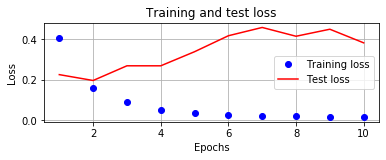

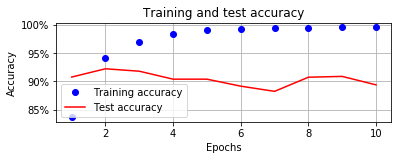

In [28]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(val_loss_values) + 1)

plt.subplot(211)
plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()


plt.subplot(212)
plt.plot(epochs, history.history['acc'], 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'r', label='Test accuracy')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

# Sentiment classification using stacked LSTM

In [29]:
embedding_vecor_length=32
max_review_length=26
model = Sequential()
model.add(Embedding(input_dim=12533, output_dim=32, input_length = 26))
model.add(LSTM(40, return_sequences=True,name='lstm1'))
model.add(LSTM(40, return_sequences=False,name='lstm2'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 26, 32)            401056    
_________________________________________________________________
lstm1 (LSTM)                 (None, 26, 40)            11680     
_________________________________________________________________
lstm2 (LSTM)                 (None, 40)                12960     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 82        
Total params: 425,778
Trainable params: 425,778
Non-trainable params: 0
_________________________________________________________________
None


In [30]:
W = model.layers[2].get_weights()[0]
U = model.layers[2].get_weights()[1]
b = model.layers[2].get_weights()[2]
print(W.shape,U.shape,b.shape)

(40, 160) (40, 160) (160,)


In [31]:
history = model.fit(X_train, y_train2, validation_data=(X_test, y_test2), epochs=10, batch_size=32)

Train on 8078 samples, validate on 3463 samples
Epoch 1/10
8078/8078 [==============================] - 12s 2ms/step - loss: 0.3691 - acc: 0.8505 - val_loss: 0.2268 - val_acc: 0.9116
Epoch 2/10
8078/8078 [==============================] - 9s 1ms/step - loss: 0.1450 - acc: 0.9465 - val_loss: 0.2121 - val_acc: 0.9220
Epoch 3/10
8078/8078 [==============================] - 9s 1ms/step - loss: 0.0785 - acc: 0.9754 - val_loss: 0.2407 - val_acc: 0.9197
Epoch 4/10
8078/8078 [==============================] - 9s 1ms/step - loss: 0.0485 - acc: 0.9851 - val_loss: 0.3088 - val_acc: 0.9105
Epoch 5/10
8078/8078 [==============================] - 10s 1ms/step - loss: 0.0400 - acc: 0.9875 - val_loss: 0.3576 - val_acc: 0.9142
Epoch 6/10
8078/8078 [==============================] - 9s 1ms/step - loss: 0.0264 - acc: 0.9926 - val_loss: 0.3507 - val_acc: 0.9096
Epoch 7/10
8078/8078 [==============================] - 9s 1ms/step - loss: 0.0180 - acc: 0.9955 - val_loss: 0.5165 - val_acc: 0.9076
Epoch 8/10
8

We can see that the accuracy of our model is ~89% in predicting the sentiment of a tweet.

Plot the confusion matrix of predictions.

In [32]:
pred = model.predict(X_test)
pred2 = np.where(pred>0.5,1,0)
pred_class= argmax(pred2, axis=1)
confusion_matrix(y_test, pred_class)

array([[2509,  260],
       [ 126,  568]], dtype=int64)

From the above, we see that in 2,509 sentences, we predicted them to be positive and they are actually positive. 260 sentences were predicted to be negative and happened to be positive. 126 sentences were predicted to be positive and happened to be negative and finally, 568 sentences were predicted negative and were actually negative.

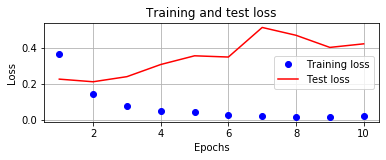

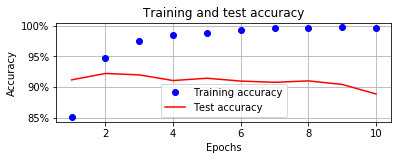

In [33]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(val_loss_values) + 1)

plt.subplot(211)
plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()


plt.subplot(212)
plt.plot(epochs, history.history['acc'], 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'r', label='Test accuracy')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()